In [315]:
import pandas as pd
from textblob import TextBlob
import re
import pickle
import tweepy

users = ['elonmusk' ,'cristiano','BarackObama', 'billgates','cnnbrk','joebiden','justinbieber','KimKardashian','theellenshow','twitter','youtube']

def read_list():
    with open('bin_data/data.pkl', 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

tweets = read_list()

all_tweets = [ [ tweepy.Tweet(twt) for twt in user_tweets ] for user_tweets in tweets]

In [345]:
emoji = re.compile("["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030" "]+", re.UNICODE)

def is_elon_musk_tweet(tweet):
    elon_musk_id = 44196397
    return [tweet.author_id == elon_musk_id]

def has_link(tweet):
    pattern = re.compile(r"http\S+")
    if pattern.search(tweet) is not None:
        return 1
    return 0 

def has_hashtag(tweet):
    pattern = re.compile('#[A-Za-z0-9]+')
    return  1 if pattern.search(tweet) != None else 0

def has_emoji(tweet,emoji=emoji):
    pattern = re.compile(emoji)
    return  1 if pattern.search(tweet) != None else 0

def has_at(tweet):
    pattern = re.compile('#[A-Za-z0-9]+')
    return  1 if pattern.search(tweet) != None else 0

def clean_tweet(tweet, emoji = emoji):
    tweet = re.sub('#[A-Za-z0-9]+', '', tweet)
    tweet = re.sub('\\n', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub('@[\S]*', '', tweet) 
    tweet = re.sub('^[\s]+|[\s]+$', '', tweet) #white spaces
    tweet = re.sub(emoji, '', tweet)
    return tweet

def has_text(tweet):
    if len(clean_tweet(tweet)):
        return 1
    return 0

def get_tweet_sentiment(tweet):  
    cleaned_text = clean_tweet(tweet.text)
    if len(cleaned_text):
        analysis = TextBlob(clean_tweet(tweet.text))
        return [analysis.sentiment.polarity]
    return [2]

def get_tweet_subjectivity(tweet):  
    cleaned_text = clean_tweet(tweet.text)
    if len(cleaned_text):
        analysis = TextBlob(clean_tweet(tweet.text))
        return [analysis.sentiment.subjectivity]
    return [2]

def getSentiment(value):
  if value == 2:
    return 'NoSentiment'
  if value < 0:
    return 'Negative'
  elif value > 0:
    return 'Positive'
  else:
    return 'Neutral'

def get_basic_tweet_data(tweet):
    elon_musk_id = 44196397
    return [ 1 if tweet.author_id == elon_musk_id else 0,
            tweet.created_at, 
            tweet.source,
            tweet.possibly_sensitive,
            tweet.lang,
            has_text(tweet.text),
            has_link(tweet.text),
            has_hashtag(tweet.text),
            has_at(tweet.text),
            has_emoji(tweet.text)
            ]

def get_public_metrics(tweet):
    return tweet.public_metrics.values()

def connect_generated_tweets_data(tweet, functions):
    data_row = []
    for function in functions:
        data_row.extend(function(tweet))
    return data_row

def make_pd_data_frame(tweets, columns, tweet_data_extract_functions, user, prefix_for_file = 'basic'):
    data_rows = [ connect_generated_tweets_data(tweet, tweet_data_extract_functions) for tweet in tweets]
    df = pd.DataFrame(data=data_rows, columns=columns)
    df.to_csv(f'user_data/{prefix_for_file}_{user}_tweets.csv',index=False)

    return df

def get_all_data_frames_and_save_them(all_tweets, users, columns, tweet_data_extract_functions, prefix_for_file = 'basic'):
    data_frames = [] 
    for index, user in enumerate(users):
        data_frame = make_pd_data_frame(all_tweets[index], columns, tweet_data_extract_functions, user, prefix_for_file)
        data_frames.append(data_frame)
    return data_frames



### Ekstrakcja podstawowych informacji  

In [357]:

columns=[
    'is Elon Musk',
    'created at',
    'source',
    'possibly sensitive',
    'lang',
    'has_text',
    'has_link',
    'has_hashtag',
    'has_at',
    'has_emoji',
    'sentiment',
    'retweet count',
    'reply count',
    'like count',
    'quote count']
tweet_data_extract_functions = [get_basic_tweet_data,get_tweet_sentiment, get_public_metrics]

data_frames = get_all_data_frames_and_save_them(all_tweets, users, columns, tweet_data_extract_functions)

main_df = pd.concat([data_frame for data_frame in data_frames],ignore_index=True,sort=False)


In [358]:
main_df.head(8000)

,is Elon Musk,created at,source,possibly sensitive,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,retweet count,reply count,like count,quote count
0,1,2022-12-12 19:46:04+00:00,Twitter for iPhone,False,und,0,1,0,0,1,2.000000,20135,14379,238424,3363
1,1,2022-12-12 19:36:52+00:00,Twitter for iPhone,False,en,1,1,0,0,0,0.000000,27679,9635,118548,1714
2,1,2022-12-12 14:21:31+00:00,Twitter for iPhone,False,en,1,0,0,0,0,0.800000,37603,27237,337208,4261
3,1,2022-12-12 12:25:32+00:00,Twitter for iPhone,False,en,1,0,0,0,0,0.000000,66507,42222,470431,10681
4,1,2022-12-12 11:24:29+00:00,Twitter for iPhone,False,en,1,0,0,0,0,0.000000,10073,6045,138343,522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,0,2022-04-14 04:08:23+00:00,Twitter for iPhone,False,art,0,1,0,0,1,2.000000,50,46,902,1
7554,0,2022-04-14 04:08:05+00:00,Twitter for iPhone,False,en,1,1,0,0,0,0.000000,48,42,937,4
7555,0,2022-04-14 04:07:45+00:00,Twitter for iPhone,False,en,1,1,0,0,0,0.915527,52,96,1246,2
7556,0,2022-04-14 03:58:51+00:00,Twitter for iPhone,False,en,1,0,0,0,0,-0.610352,447,708,14352,115


In [348]:
main_df.groupby(by='is Elon Musk')['source'].value_counts()

is Elon Musk  source                  
0             Twitter Web App             1868
              Twitter for iPhone          1805
              Twitter Media Studio         944
              SocialFlow                   808
              Sprout Social                649
              Sprinklr                     588
              Twitter Web Client           160
              swonkie                       12
              Twitter for Advertisers.       4
              TweetDeck                      3
              Twitter Ads                    2
              Arrow.                         1
              Instagram                      1
              Periscope                      1
              Twitter for  iPhone            1
              Twitter for Android            1
              Twitter for Mac                1
1             Twitter for iPhone           709
Name: source, dtype: int64

In [349]:
main_df = main_df.groupby('source').filter(lambda x : len(x) > 12)
main_df.groupby(by='is Elon Musk')['source'].value_counts()

In [351]:
main_df.groupby(by='is Elon Musk')['lang'].value_counts()

is Elon Musk  lang
0             en      6092
              und      229
              pt       119
              art      101
              zxx       89
              it        62
              es        54
              qst       14
              fr        13
              qme       13
              tl         9
              de         4
              et         4
              cy         3
              qht        3
              in         2
              ja         2
              nl         2
              tr         2
              ca         1
              ht         1
              lt         1
              qam        1
              ro         1
1             en       605
              zxx       65
              und       10
              art        4
              fr         4
              pt         4
              es         3
              qst        3
              da         2
              de         2
              el         1
              et         1
         

In [352]:
values = ['en','art','zxx']
main_df = main_df[main_df.lang.isin(values) == True]
main_df.groupby(by='is Elon Musk')['lang'].value_counts()

is Elon Musk  lang
0             en      6092
              art      101
              zxx       89
1             en       605
              zxx       65
              art        4
Name: lang, dtype: int64

In [ ]:
main_df.to_csv('main_df.csv', index=False)

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.figure(figsize = (8,6))

markers = {'Positive':'o', 'Neutral':'s','Negative':'X', 'NoSentiment' : 'v'}

sns.scatterplot(data=data_frames[0], x='polarity', y='subjectivity', hue = 'sentiment', style = 'sentiment', markers = markers, palette = 'gist_earth').set(xlim=(-1.1,1.1))
plt.title('Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()

ValueError: Could not interpret value `polarity` for parameter `x`

<Figure size 576x432 with 0 Axes>

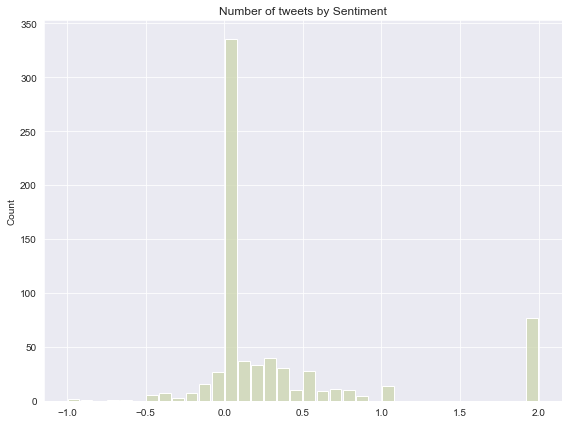

In [354]:
plt.figure(figsize = (8,6))

sns.histplot(data_frames[0], x = 'sentiment', color = '#ccd5ae', shrink = 0.9).set(xlabel = None)
plt.title('Number of tweets by Sentiment')

plt.tight_layout()

ValueError: 'label' must be of length 'x'

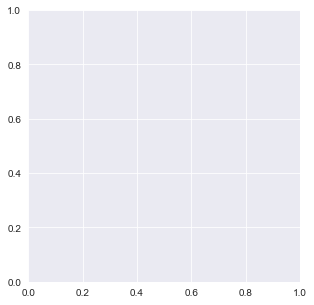

In [355]:
plt.figure(figsize = (10, 5))

data = data_frames[0]['sentiment'].value_counts()
colors = sns.color_palette('GnBu')
labels = ['Positive', 'Neutral', 'Negative','NoSentiment']

plt.pie(data, labels = labels, autopct = '%.0f%%', colors = colors)
plt.title('Number of likes by sentiment')

plt.tight_layout()

### Wycinanie kontekstu tweeta

In [342]:
def get_value_from_dict(tweet, name='annotations'):
    dict = tweet.entities
    if dict is not None:
        dict = dict.get(name)
        if dict is not None:
            return [ [dict[0]['probability'], dict[0]['normalized_text'], dict[0]['type']] ]
    return [None]

def get_context_annotations_domain_value(tweet, context_annotations_number=0, key='domain'):
    context_annotations = tweet.context_annotations

    if len(context_annotations) > context_annotations_number:
        return context_annotations[context_annotations_number][key]['name']
    return None

def create_columns_for_annotations_data(number_of_instances=6):
    annotations_columns = ['is Elon Musk']
    for i in range(number_of_instances):
        annotations_columns.extend([f'context annotations domain {i}', f'context annotations entity {i}'])
    
    annotations_columns.append('annotations')
    return annotations_columns
    
def get_all_annotations_data(tweet, number_of_instances=6):
    annotations_data = []
    for i in range(number_of_instances):
        annotations_data.extend([
            get_context_annotations_domain_value(tweet, i),
            get_context_annotations_domain_value(tweet, i, 'entity')])
    
    return annotations_data

columns = create_columns_for_annotations_data()
tweet_data_extract_functions = [is_elon_musk_tweet, get_all_annotations_data, get_value_from_dict]

data_frame_annotation = get_all_data_frames_and_save_them(all_tweets, users, columns, tweet_data_extract_functions, 'annotations')
data_frame_annotation[0].head(800)

,is Elon Musk,context annotations domain 0,context annotations entity 0,context annotations domain 1,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,None
1,True,Person,Donald Trump,Politician,Donald Trump,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,"[0.9636, Twitter, Other]"
2,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9003, Covidians, Other]"
3,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,None
4,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,True,Video Game,Starlink: Battle for Atlas,Unified Twitter Taxonomy,Gaming,Unified Twitter Taxonomy,Starlink: Battle for Atlas,Unified Twitter Taxonomy,Video games,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,"[0.9838, Brazil, Place]"
705,True,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Entities [Entity Service],Technology,Unified Twitter Taxonomy,Elon Musk,Unified Twitter Taxonomy,Tech personalities,"[0.7635, Elongate, Person]"
706,True,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Entities [Entity Service],Technology,Unified Twitter Taxonomy,Elon Musk,Unified Twitter Taxonomy,Tech personalities,None
707,True,Interests and Hobbies,Mergers & Acquisitions,Person,Elon Musk,Entities [Entity Service],Auto Manufacturer - Auto,Entities [Entity Service],Services,Brand,Tesla Motors,Brand,Twitter,"[0.9844, Twitter, Other]"
